In [ ]:
mydrive = "/work/Chess/"
stockfish_path = mydrive + "Stockfish/stockfish_14.1_linux_x64_avx2/"

In [ ]:
# """ Initial Installation for StockFish """

# %cd /work
# !mkdir Chess
# !mkdir Chess/Stockfish
# %cd /work/Chess/Stockfish
# !wget https://stockfishchess.org/files/stockfish_14.1_linux_x64_avx2.zip
# !unzip stockfish_14.1_linux_x64_avx2.zip
# !rm stockfish_14.1_linux_x64_avx2.zip
# !chmod +x {stockfish_path}"stockfish_14.1_linux_x64_avx2"

In [ ]:
!pip install stockfish
!pip install python-chess

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 147 kB 25.8 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Game State Representation

In [ ]:
# Most of this cell is rip-off from python-chess library
# We overwrite existing classes and functions for our requirements

import chess
from chess import SQUARES, BB_RANKS, BB_SQUARES, BB_BACKRANKS

def square(file_index: int, rank_index: int):
    """Gets a square number by file and rank index."""
    return rank_index * 8 + file_index

class ChessBoard(chess.Board):
    def find_move(self, from_square, to_square, promotion=None):
        """
            Overridden to suppress move validation
        """
        # if promotion is None and self.pawns & BB_SQUARES[from_square] and BB_SQUARES[to_square] & BB_BACKRANKS:
            # promotion = QUEEN

        return self._from_chess960(self.chess960, from_square, to_square, promotion)

class LegalMoves(chess.LegalMoveGenerator):
    """ Add a new method to existing class to get desired format of moves """
    def to_array(self):
        return [self.board.lan(move) for move in self]

51
Black to move


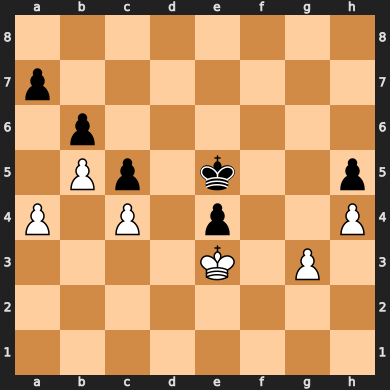

In [ ]:
import chess
import numpy as np

from stockfish import Stockfish
from chess import LegalMoveGenerator
from IPython.display import display

stockfish = Stockfish(stockfish_path + "stockfish_14.1_linux_x64_avx2")

def uci(move):
    move = move.replace("+", "")
    return move[-5:].replace("-", "")

def inverse(move):
    return move[2:] + move[:2]

def flip_move(position):
    arr = position.split()
    arr[1] = "b" if arr[1] == "w" else "w"
    return " ".join(arr)

class State:
    def __init__(self, fen: str, parent: str=None, move: str=None) -> None:
        self.fen = fen
        self.parent = parent
        self.children = []

    def add_child(self, fen_position: str) -> list:
        self.children.append(fen_position)
        return self.children

    @property
    def board(self) -> object:
        display(chess.Board(self.fen))

    def __str__(self) -> str:
        return f"{self.fen}: {[str(x.fen) for x in self.children]}"

    def __repr__(self) -> str:
        return self.__str__()


class MoveGenerator:
    """
        Previous moves list:
            1. All possible legal (non-pawn) moves at a given position (Breaks down if opponent is in check)
            2. Pawn Moves (back + uncapture)
            3. En Passant (MAYBE we can skip this)
            4. All possible legal moves + uncapture the moves
            5. Un-Castle (not a priority)
    """
    def __init__(self) -> None:
        self.mapper = np.linspace(1, 64, num=64, dtype=int).reshape((8,8))
        self.map_fen = {alpha: num for alpha, num in zip("abcdefgh", range(8))}

    @staticmethod
    def board_numpy(board) -> str:
        """ Return 2d array for the board position """
        board = board.split()[0].split("/")

        arr = list()
        
        for row in board:
            res = ""
            for val in row:
                if val.isnumeric():
                    res += int(val) * "-"
                else:
                    res += val
            arr.append(list(res))

        return np.array(arr)

    def index_to_fen(self, index: int) -> str:
        """ Convert 64-value index to board position """
        x, y = 8 - ((index - 1) // 8), (index - 1) % 8
        y = "abcdefgh"[y]

        return y + str(x) 

    def get_legal_moves(self, fen_pos: str) -> list:
        board = ChessBoard(fen_pos)
        legal = LegalMoves(board).to_array()
        return [uci(x) for x in legal if not x.islower() and "x" not in x]

    def get_capture_moves(self, fen_pos: list) -> list:
        # TODO: Replace with all moves
        moves = self.get_legal_moves(fen_pos)
        moves = [move for move in moves if "x" in move]
        return moves

    def get_pawn_moves(self, fen_pos: str) -> None:
        """ 
            Returns a tuple of (legal_moves, uncapture_moves) for all pawns of player in the given board
            legal_moves: All non-capture moves from board (NOTE: does not validate for discover check)
            uncapture_moves: Possible uncapture moves for all pawns (does not validate anything)
                                -> Requires post-process for which piece to be uncaptured
        """
        player = fen_pos.split()[1]
        fen_pos = MoveGenerator.board_numpy(fen_pos)

        possible_moves, uncapture_moves = [], []

        available_pieces = list(zip(*np.where(fen_pos ==  'P'))) if player == "w" \
                        else list(zip(*np.where(fen_pos ==  'p')))

        updates = {
            "w": {
                "legal": lambda x: x < 6,
                "double_move": lambda x: x == 4,
                "update_one": 8,
                "update_two": 16,
                "capture_left": 7,
                "capture_right": 9,
            },

            "b": {
                "legal": lambda x: x > 1,
                "double_move": lambda x: x == 3,
                "update_one": -8,
                "update_two": -16,
                "capture_left": -9,
                "capture_right": -7,
            }
        }

        for piece in available_pieces:
            if updates[player]["legal"](piece[0]):
                mapper_number = self.mapper[piece[0]][piece[1]]
                possible_moves.append((mapper_number, (mapper_number + updates[player]["update_one"])))
                if updates[player]["double_move"](piece[0]):
                    possible_moves.append((mapper_number, (mapper_number + updates[player]["update_two"])))
                uncapture = [(mapper_number, mapper_number + updates[player]["capture_left"]), 
                            (mapper_number, mapper_number + updates[player]["capture_right"])]
                uncapture_moves.extend(uncapture)


        legal_pawn_moves = [
            self.index_to_fen(initial) + self.index_to_fen(end)
            for initial, end in possible_moves
            if fen_pos[np.where(self.mapper == end)] == '-'
        ]

        moves_to_remove = []
        # Illegal pawn uncaptures (when space is not empty)
        for move in uncapture_moves:
            row, column = np.where(self.mapper == move[1])
            row, column = row[0], column[0]
            if(fen_pos[row][column] != '-'):
                moves_to_remove.append(move)

        uncapture_moves = [i for i in uncapture_moves if i not in moves_to_remove]

        uncapture_pawn_moves = [self.index_to_fen(initial) + self.index_to_fen(end) for initial, end in uncapture_moves]
        
        for move in uncapture_pawn_moves:
            move1 = int(move[1])
            move3 = int(move[3])
            if abs(move1 - move3) > 1 or abs(move1 - move3) == 0:
                uncapture_pawn_moves.remove(move)
        return {
            "back": legal_pawn_moves,
            "uncapture": uncapture_pawn_moves
        }

    def get_uncapture_moves(self, fen_pos:str, moves: list) -> list:
        """ Return a list of FEN states that can be possible "uncapture" moves """

        fen_numpy = MoveGenerator.board_numpy(fen_pos)
        player = fen_pos.split()[1]
        opponent = "w" if player == "b" else "b"

        # All chess pieces
        pieces = ['P']*8 + ['R'] + ['N'] + ['B'] + ['Q'] + ['K'] + ['B'] + ['N'] + ['R']

        # Fetch pieces already on the board
        if(opponent == 'b'):
            pieces = [piece.lower() for piece in pieces]
            pieces_on_board = [character for character in fen_pos.split()[0] if character.islower()]            
        else:
            pieces_on_board = [character for character in fen_pos.split()[0] if character.isupper()]

        # Pieces not on the board
        for piece in pieces_on_board:
            pieces.remove(piece)

        # The same pieces will generate same uncapture states, so eliminate duplicates
        uncapture_pieces = list(set(pieces))

        previous_fens = []

        # Outer loop for each move
        for move in moves:

            # Play the reverse chess move
            board = ChessBoard(fen_pos)
            board.push_san(move)

            # For each piece for the current move
            for piece in uncapture_pieces:
                
                # Split fen into chess board rows
                rows_list = board.fen().split('/')
                
                # Retrieve the row string and column to insert the uncapture piece
                row = rows_list[8-int(move[1])]
                column_index = self.map_fen[move[0]]

                # Convert the row string into list of characters for easy string manipulation
                row = MoveGenerator.board_numpy(row)[0]

                # Add the uncapture piece
                row[column_index] = piece

                # Update the fen
                num_count = 0
                string = ""
                for char in row:
                    if char == '-':
                        num_count+=1
                    else:
                        string = string + (str(num_count) if num_count > 0 else "") + char
                        num_count = 0
                if num_count > 0:
                    string = string + str(num_count)

                rows_list[8-int(move[1])] = string
                new_fen = "/".join(rows_list)
                previous_fens.append((move, new_fen))

        return previous_fens

    def get_all_moves(self, fen_pos: str):
        fen_pos = fen_pos.split()
        fen_pos[1] = "w" if fen_pos[1] == "b" else "b"
        fen_pos = " ".join(fen_pos)
        player = fen_pos.split()[1]
        board = ChessBoard(fen_pos)

        legal = self.get_legal_moves(fen_pos)

        pawns = self.get_pawn_moves(fen_pos)
        uncapture_fens = self.get_uncapture_moves(board.fen(), legal) + self.get_uncapture_moves(board.fen(), pawns["uncapture"])

        pawns_back = pawns["back"]
        legal_fens = []
        pawns_back_fen = []

        for move in legal:
            board = ChessBoard(fen_pos)
            board.push_san(move)

            legal_fens.append((move, board.fen()))

        for move in pawns_back:
            board = ChessBoard(fen_pos)
            board.push_san(move)
            pawns_back_fen.append((move, board.fen()))

        return legal_fens + pawns_back_fen + uncapture_fens

class GameState:

    def __init__(self, initial_state: str) -> None:
        self.initial = State(initial_state)
        self.board = chess.Board(initial_state)
        self.stockfish = Stockfish
        self.move_generator = MoveGenerator()

    @property
    def player(self) -> str:
        """ Returns the player (w/b)"""
        return self.board.fen().split()[1]
    
    @property
    def display_board(self) -> None:
        print(f"{'White' if self.player == 'w' else 'Black'} to move")
        display(self.board)

    def get_all_moves(self) -> None:
        # Main function to get all possible backtrack moves
        # self.get_pawn_moves()
        # self.get_legal_reverse_moves()
        # self.get_special_moves()

        return self.move_generator.get_all_moves(self.board.fen())

    def flip_board(self) -> None:
        # Flips the board and player's turn
        self.board = board.mirror()
        self.display_board()

#test_position = "2b2rk1/7p/6p1/RN1Pp3/1Pp1Pp2/6qP/1Q2B1P1/5K2 w - - 0 30"
test_position = "8/p7/1p6/1Pp1k2p/P1P1p2P/4K1P1/8/8 b - - 2 45"
game = GameState(test_position)
print(len([x[0] for x in game.get_all_moves()]))
game.display_board

In [ ]:
board = chess.Board("6k1/5ppp/8/4P1q1/8/2N5/P5KP/5R2 b - - 0 31")
board.is_valid()

False

In [ ]:
np.linspace(1, 64, num=64, dtype=int).reshape((8,8))

array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30, 31, 32],
       [33, 34, 35, 36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45, 46, 47, 48],
       [49, 50, 51, 52, 53, 54, 55, 56],
       [57, 58, 59, 60, 61, 62, 63, 64]])

# Heuristics



1.   Sacrifice: $$\frac{(w_1 - w_2) - (b_1 - b_2)}{m}, m \subset \{9.5, 15.13, 20.76...\}$$
2.   Pin: $$$$
3.   Fork: $$\frac{1}{f_c}(\frac{\sum_{i=1}^{n} v(f_{p_n})}{v(f_k)} + n)$$
4.   Material Disadvantage: $$\frac{(b_1 - w_1)}{m}, m=41.52$$
$m$ is total material value - Should we use total? Or total of the board?
5.   Using all peice power? Debatable - coz compact positions make beautiful puzzles as well
6.   Smoothered Mate? - If we value this, it would be quite a bias?


In [ ]:
from collections import Counter

class Heuristics:
    ADVANTAGE_THRESHOLD = 0.95
    PIN_THRESHOLD = 0.0
    FORK_THRESHOLD = 0.05
    SACRIFICE_THRESHOLD = 0.0

    def __init__(self, values: dict=None) -> None:
        # Defining inital material value (weights from AlphaZero)
        self.values = {
            'p': 1.00,
            'n': 3.05,
            'b': 3.33,
            'r': 5.63,
            'q': 9.50,
            'k': 0.00 # we don't consider king's value when counting material
        }
        if values:
            self.values = values

        self.map_fen = {alpha: num for alpha, num in zip("abcdefgh", range(8))}

        # List of all constants
        # Through previous literature, updated with AlphaZero weights
        self.pin_constant = 21
        self.fork_constant = 41.52
        self.sacrifice_constant = [9.50, 15.13, 20.76, 24.09, 27.42]
        self.material_disadvantage_constant = 41.52

        self.heuristic_functions = {
            "Material": self.material_disadvantage,
            "Sacrifice": self.sacrifice,
            "Pin": self.pin,
            "Fork": self.fork,

        }

        self.move_generator = MoveGenerator()
        self.stockfish = Stockfish(stockfish_path + "stockfish_14.1_linux_x64_avx2")
        self.stockfish.set_depth(10)

    def get_piece_pos(self, piece):
        col, row = piece
        row = 8 - int(row)
        col = self.map_fen[col]

        return row, col

    def check_straight_lines(self, board, row, column, friendly_pieces, values):
        # vertical

        pins = []
        the_value = -100
        for target_row in range(row-1, -1, -1):
            if board[target_row][column] in friendly_pieces:
                break
            if board[target_row][column] == '-':
                continue
            if the_value == -100:
                the_value = values[board[target_row][column].lower()]
            else:
                # what if next->next->next's value is larger than next->next's but next->next's value is smaller than next's
                new_value = values[board[target_row][column].lower()]
                if new_value > the_value:
                    pins.append(new_value + the_value)
                    break
        the_value = -100        
        for target_row in range(row+1, 8):
            if board[target_row][column] in friendly_pieces:
                break
            if board[target_row][column] == '-':
                continue
            if the_value == -100:
                the_value = values[board[target_row][column].lower()]
            else:
                new_value = values[board[target_row][column].lower()]
                if new_value > the_value:
                    pins.append(new_value + the_value)
                    break

        # horizontal
        the_value = -100
        for target_column in range(column-1, -1, -1):
            if board[row][target_column] in friendly_pieces:
                break
            if board[row][target_column] == '-':
                continue
            if the_value == -100:
                the_value = values[board[row][target_column].lower()]
            else:
                new_value = values[board[row][target_column].lower()]
                if new_value > the_value:
                    pins.append(new_value + the_value)
                    break
        the_value = -100
        for target_column in range(column+1, 8):
            if board[row][target_column] in friendly_pieces:
                break
            if board[row][target_column] == '-':
                continue
            if the_value == -100:
                the_value = values[board[row][target_column].lower()]
            else:
                new_value = values[board[row][target_column].lower()]
                if new_value > the_value:
                    pins.append(new_value + the_value)
                    break
        
        return pins

    def get_pinned_pieces(self, fen_position: str) -> dict:
        values = self.values
        values['k'] = 15

        white_pieces = 'RNBQKP'
        black_pieces = 'rnbqkp'

        player = fen_position.split()[1]
        friendly_pieces = black_pieces if player == 'b' else white_pieces
        board_array = MoveGenerator.board_numpy(fen_position)
                
        pinned_pieces = []
        for row in range(8):
            for column in range(8):
                piece = board_array[row][column]
                if piece in friendly_pieces:
                    the_value = -100
                    found = 0
                    if piece.lower() in ['r', 'q']:
                        straight_pins = self.check_straight_lines(board_array,row,column,friendly_pieces,values)
                        if len(straight_pins) > 0:
                            pinned_pieces.append(max(straight_pins))

        return pinned_pieces

    def total_material(self, fen_position: str, **args) -> (float, float):
        fen = fen_position.split()[0]
        fen = [piece for piece in fen if piece.isalpha()]
        counter = Counter(fen)

        white_material = 0
        black_material = 0

        for piece, count in counter.items():
            if piece.isupper():
                white_material += count * self.values[piece.lower()]
            else:
                black_material += count * self.values[piece]

        white_material, black_material = round(white_material, 2), round(black_material, 2)
        return white_material, black_material

    def stockfish_evaluation(self, fen_position: str, *args) -> dict:
        self.stockfish.set_fen_position(fen_position)
        return self.stockfish.get_evaluation()

    def material_disadvantage(self, fen_position: str, *args) -> (bool, float):
        white, black = self.total_material(fen_position=fen_position)
        return white * Heuristics.ADVANTAGE_THRESHOLD > black, (white - black) / self.material_disadvantage_constant

    def sacrifice(self, fen_position_initial: str, fen_position_end: str, num_moves: int) -> (bool, float):
        if not fen_position_end:
            return False, 0
        white_initial, black_initial = self.total_material(fen_position=fen_position_initial)
        white_end, black_end = self.total_material(fen_position=fen_position_end)

        sacrifice_value = ((white_initial - white_end) - (black_initial - black_end)) / self.sacrifice_constant[num_moves - 1]
        
        return sacrifice_value > Heuristics.SACRIFICE_THRESHOLD, sacrifice_value

    def pin(self, fen_position: str, *args) -> (bool, float):
        pin_value = 0 # TODO: Calculate the pin value
        values = self.get_pinned_pieces(fen_position)
        if values:
            pin_value = max(pin_value, max(values) / self.pin_constant)
        
        return pin_value > Heuristics.PIN_THRESHOLD, pin_value

    def fork(self, fen_position: str, *args) -> (bool, float):
        moves = self.move_generator.get_capture_moves(fen_position)
        board_numpy = MoveGenerator.board_numpy(fen_position)

        fork_value = 0 # TODO: Calculate the pin value

        captures = {}
        for move in moves:
            if move[:2] in captures:
                captures[move[:2]].append(move[3:])
            else:
                captures[move[:2]] = [move[3:]]

        for key, value in captures.items():
            row, col = self.get_piece_pos(key)
            key = board_numpy[row][col]
            
            if len(value) > 1:
                forks = []
                for captured_piece in value:
                    row, col = self.get_piece_pos(captured_piece)
                    piece = board_numpy[row][col]

                    if self.values[piece.lower()] >= self.values[key.lower()]:
                        forks.append(piece)
                if len(forks) > 1:
                    # run fork formula here
                    fork_value += (1/self.fork_constant) * (sum([self.values[piece.lower()] for piece in forks]) / self.values[key.lower()] + len(forks))

        return fork_value > Heuristics.FORK_THRESHOLD, fork_value

    def get_all_heuristics(self, fen_position_start: str, fen_position_end: str=None, num_moves=None) -> (dict, float):
        result = {}
        total = 0
        for name, func in self.heuristic_functions.items():
            flag, val = func(fen_position_start, fen_position_end, num_moves)
            if flag:
                total += val
            result[name] = (flag, val)
        # result["stockfish"] = self.stockfish_evaluation(fen_position_start)
        return result, total

test_position = "2rk3r/1b1p1p1q/q6R/1p2Rp2/2q5/2P2P2/P1P3PP/5R1K w - - 1 21"
# test_position = "r1b5/5pkp/N4p2/R7/2P5/K7/P5PP/8 b - - 0 27" # Pin
heur = Heuristics()
result, total = heur.get_all_heuristics(test_position)
print(f"Material Disadvantage: {result}\nTotal: {round(total, 2)}")

Material Disadvantage: {'Material': (False, -0.5828516377649325), 'Sacrifice': (False, 0), 'Pin': (False, 0), 'Fork': (False, 0)}
Total: 0


In [ ]:
print(len(game.get_all_moves()))
print(len([x[0] for x in game.get_all_moves()]))

51
51


In [ ]:
def valid_moves(position):
    game = GameState(position)
    validated_states = []
    print(len(game.get_all_moves()))
    for moves, fens in game.get_all_moves():
        move = moves[2:] + moves[:2]
        
        print(move, fens)

        fen = fens.split()
        fen[1] = "b" if fen[1] == "w" else "w"
        fen = " ".join(fen)
        board = chess.Board(fen)
        if board.is_valid():
            legal = [uci(x).replace("x", "") for x in LegalMoves(board).to_array()]
            if move in legal:
                validated_states.append((moves, fens))
    print(len(validated_states))
    return validated_states

In [ ]:
import random
import time
position = "8/8/p6p/5p1P/1Pk2P2/4K3/8/8 w - - 2 40"
position = "6k1/5ppp/8/4P3/8/2N1q3/P5KP/5R2 w - - 0 31"

queue = [position]
count = 0
stockfish = Stockfish(stockfish_path + "stockfish_14.1_linux_x64_avx2")
stockfish.set_depth(8)
_start = time.time()
for i in range(4):
    print("Depth: ", i)
    filtered = []
    while queue:

        position = queue.pop()
        print(position)
        moves = valid_moves(position)
        print("Valid Moves: ", len(moves))
        print([x[0] for x in moves])
        stockfish.set_fen_position(position)
        filtered = []

        for move, fen in moves:
            move = move[2:] + move[:2]
            fen = fen.split()
            fen[1] = "b" if fen[1] == "w" else "w"
            fen = " ".join(fen)

            stockfish.set_fen_position(fen)
            top_moves = stockfish.get_top_moves(1)
            if move in top_moves[0]["Move"]:
                count += 1
                board = ChessBoard(fen)
                val = heur.get_all_heuristics(fen)
                filtered.append((move, fen, top_moves[0]["Centipawn"], val))

        position = position.split()
        position[1] = "w" if position[1] == "b" else "b"
        position = " ".join(position)
        filtered.sort(key=lambda x: x[2])
        filtered = filtered[:5]
        filtered = [move[1] for move in filtered]
        print(filtered)
    queue.extend(filtered)
print(count)
print(time.time() - _start)

Depth:  0
6k1/5ppp/8/4P3/8/2N1q3/P5KP/5R2 w - - 0 31
120
h8g8 7k/5ppp/8/4P3/8/2N1q3/P5KP/5R2 w - - 1 32
f8g8 5k2/5ppp/8/4P3/8/2N1q3/P5KP/5R2 w - - 1 32
a7e3 6k1/q4ppp/8/4P3/8/2N5/P5KP/5R2 w - - 1 32
h6e3 6k1/5ppp/7q/4P3/8/2N5/P5KP/5R2 w - - 1 32
b6e3 6k1/5ppp/1q6/4P3/8/2N5/P5KP/5R2 w - - 1 32
g5e3 6k1/5ppp/8/4P1q1/8/2N5/P5KP/5R2 w - - 1 32
c5e3 6k1/5ppp/8/2q1P3/8/2N5/P5KP/5R2 w - - 1 32
f4e3 6k1/5ppp/8/4P3/5q2/2N5/P5KP/5R2 w - - 1 32
e4e3 6k1/5ppp/8/4P3/4q3/2N5/P5KP/5R2 w - - 1 32
d4e3 6k1/5ppp/8/4P3/3q4/2N5/P5KP/5R2 w - - 1 32
h3e3 6k1/5ppp/8/4P3/8/2N4q/P5KP/5R2 w - - 1 32
g3e3 6k1/5ppp/8/4P3/8/2N3q1/P5KP/5R2 w - - 1 32
f3e3 6k1/5ppp/8/4P3/8/2N2q2/P5KP/5R2 w - - 1 32
d3e3 6k1/5ppp/8/4P3/8/2Nq4/P5KP/5R2 w - - 1 32
f2e3 6k1/5ppp/8/4P3/8/2N5/P4qKP/5R2 w - - 1 32
e2e3 6k1/5ppp/8/4P3/8/2N5/P3q1KP/5R2 w - - 1 32
d2e3 6k1/5ppp/8/4P3/8/2N5/P2q2KP/5R2 w - - 1 32
g1e3 6k1/5ppp/8/4P3/8/2N5/P5KP/5Rq1 w - - 1 32
e1e3 6k1/5ppp/8/4P3/8/2N5/P5KP/4qR2 w - - 1 32
c1e3 6k1/5ppp/8/4P3/8/2N5/P5KP/2q2R2 w 

IndexError: list index out of range

In [ ]:
# def check_diagonal_lines(board, row, column, friendly_pieces, values):
#     pins = []
#     # upper left
#     target_row = row-1
#     target_column = column-1
#     the_value = -100
#     while target_row >=0 and target_column >= 0:
#         if board[target_row][target_column] in friendly_pieces:
#             break
#         if board[target_row][target_column] == '-':
#         target_row = target_row-1
#         target_column = target_column-1
#         continue
#         if the_value == -100:
#         the_value = values[board[target_row][target_column].lower()]
#         else:
#         new_value = values[board[target_row][target_column].lower()]
#         if new_value > the_value:
#             pins.append(new_value + the_value)
#             break
#         target_row = target_row-1
#         target_column = target_column-1

#     # upper right
#     target_row = row-1
#     target_column = column+1
#     the_value = -100
#     while target_row >= 0 and target_column <= 7:
#         if board[target_row][target_column] in friendly_pieces:
#         break
#         if board[target_row][target_column] == '-':
#         target_row = target_row-1
#         target_column = target_column+1
#         continue
#         if the_value == -100:
#         the_value = values[board[target_row][target_column].lower()]
#         else:
#         new_value = values[board[target_row][target_column].lower()]
#         if new_value > the_value:
#             pins.append(new_value + the_value)
#             break
#         target_row = target_row-1
#         target_column = target_column+1

#     # lower left
#     target_row = row+1
#     target_column = column-1
#     the_value = -100
#     while target_row <= 7 and target_column >= 0:
#         if board[target_row][target_column] in friendly_pieces:
#         break
#         if board[target_row][target_column] == '-':
#         target_row = target_row+1
#         target_column = target_column-1
#         continue
#         if the_value == -100:
#         the_value = values[board[target_row][target_column].lower()]
#         else:
#         new_value = values[board[target_row][target_column].lower()]
#         if new_value > the_value:
#             pins.append(new_value + the_value)
#             break
#         target_row = target_row+1
#         target_column = target_column-1

#     # lower right
#     target_row = row+1
#     target_column = column+1
#     the_value = -100
#     while target_row <= 7 and target_column <= 7:
#         if board[target_row][target_column] in friendly_pieces:
#         break
#         if board[target_row][target_column] == '-':
#         target_row = target_row+1
#         target_column = target_column+1
#         continue
#         if the_value == -100:
#         the_value = values[board[target_row][target_column].lower()]
#         else:
#         new_value = values[board[target_row][target_column].lower()]
#         if new_value > the_value:
#             pins.append(new_value + the_value)
#             break
#         target_row = target_row+1
#         target_column = target_column+1
# return pins

8/p7/1p6/1Pp1k2p/P1P1p2P/4K1P1/8/8 w - - 2 45


['b6c7', 'c5d6', 'h5g6', 'e4d5', 'e4f5']
Valid Moves:  54


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea17c0f2-6b73-4dad-aeb1-6480d829e006' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>